In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
from lmfit import Model
import json
import math
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Importing and pre-processing the data

In [2]:
data = pd.read_csv("../Main Study (Face)/main_study_face_data_modified.csv")

In [3]:
data

,participant_id,prime_condition,prime_condition_names,trial_number,image,pre_post_prime,chose_masc
0,11,1,neutral,2,Slide11.bmp,0,0
1,11,1,neutral,3,Slide9.bmp,0,1
2,11,1,neutral,4,Slide5.bmp,0,0
3,11,1,neutral,5,Slide1.bmp,0,1
4,11,1,neutral,6,Slide18.bmp,0,1
...,...,...,...,...,...,...,...
12659,75b,5,pathogen,36,Slide20.bmp,1,1
12660,75b,5,pathogen,37,Slide2.bmp,1,1
12661,75b,5,pathogen,38,Slide10.bmp,1,1
12662,75b,5,pathogen,39,Slide14.bmp,1,0


Creating a dataset where all the duplicated b participants are removed:

In [4]:
b_participants = [p_id for p_id in list(data["participant_id"].unique()) if "b" in p_id and p_id[:-1] in list(data["participant_id"].unique())]
data_no_b = data[~data["participant_id"].isin(b_participants)]

Creating a dataset where the masculinity preference choice for image 10 is reversed. This change was made as a comment in the original code suggested that the masculinised side of image 10 may have been incorrectly assigned.

In [5]:
data_10_wrong = data.copy()
data_10_wrong.update(data_10_wrong[data_10_wrong["image"]=="Slide10.bmp"]["chose_masc"].map({0:1, 1:0}))
data_10_wrong["chose_masc"] = data_10_wrong["chose_masc"].astype(int)

Creating a dataset where all the duplicated b participants are removed AND where the image 10 result is reversed.

In [6]:
data_10_wrong_no_b = data_no_b.copy()
data_10_wrong_no_b.update(data_10_wrong_no_b[data_10_wrong_no_b["image"]=="Slide10.bmp"]["chose_masc"].map({0:1, 1:0}))
data_10_wrong_no_b["chose_masc"] = data_10_wrong_no_b["chose_masc"].astype(int)

In [7]:
def residual_plots(model):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
    fig.subplots_adjust(wspace=0.25, hspace=0.25)
    fig.suptitle("Diagnostic Plots", fontsize=15)

    axes[0][0].hist(pd.Series(model.resid_pearson), bins=15, edgecolor="white", color="dodgerblue")
    sp.stats.probplot(pd.Series(model.resid_pearson), plot=axes[0][1], fit=True)
    axes[0][2].scatter(pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_y"],
                       pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_x"], 
                       alpha=0.7, s=10, color="dodgerblue")
    axes[0][2].axhline(y=0, color="red", linestyle="-")
    axes[1][0].scatter(list(pd.Series(model.get_influence().hat_matrix_diag).index),
                       pd.Series(model.get_influence().hat_matrix_diag), alpha=0.7, s=10, color="dodgerblue")
    axes[1][1].scatter(list(pd.Series(model.get_influence().cooks_distance[0]).index),
                       pd.Series(model.get_influence().cooks_distance[0]), alpha=0.7, s=10, color="dodgerblue")
    axes[1][2].scatter(abs(pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_x"]),
                       pd.Series(model.get_influence().hat_matrix_diag), alpha=0.7, s=10, color="dodgerblue")

    axes[0][0].set_title("Residuals", fontsize=13)
    axes[0][0].text(0.55, 0.8, "Skew: {0:.2f}".format(pd.Series(model.resid_pearson).skew()), 
                    fontsize=12, horizontalalignment="left", transform=axes[0][0].transAxes,  
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    axes[0][1].set_xlabel(""), axes[0][1].set_ylabel(""), axes[0][1].set_title("Normal Plot", fontsize=13)
    axes[0][1].get_lines()[0].set_markerfacecolor("dodgerblue")
    axes[0][1].get_lines()[0].set_markersize(5)
    axes[0][1].get_lines()[0].set_markeredgecolor("None")
    axes[0][2].set_title("Fitted Values", fontsize=13), axes[0][2].set_ylabel("Standardised Residuals", fontsize=13, rotation=-90, labelpad=20)
    axes[1][0].set_title("Leverage", fontsize=13)
    axes[1][1].set_title("Cook's Distance", fontsize=13)
    axes[1][2].set_title("Residuals vs Leverage", fontsize=13);
    axes[1][2].set_xlabel("(Absolute) Standardised Residuals", fontsize=13), axes[1][2].set_ylabel("Leverage", fontsize=13, rotation=-90, labelpad=20),
    axes[1][2].yaxis.set_label_position("right"), axes[0][2].yaxis.set_label_position("right")
    axes[1][0].set_xlabel("Index", fontsize=13), axes[1][1].set_xlabel("Index", fontsize=13)

## Overall masculinity preference over time

Plotting the percent of preference for masculinity for each trial (i.e. over time):

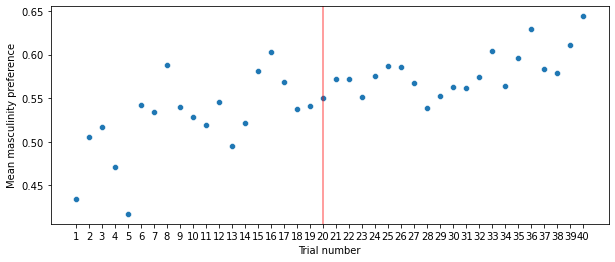

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.scatterplot(data=data.groupby("trial_number")["chose_masc"].mean(), ax=ax)
ax.axvline(20, color="red", alpha=0.5)
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

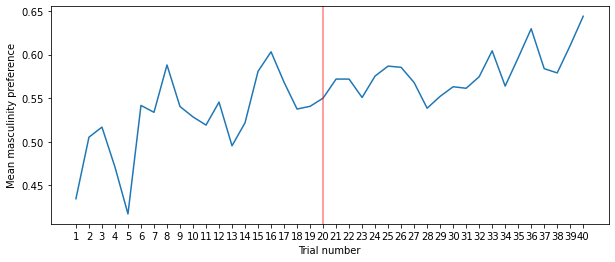

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby("trial_number")["chose_masc"].mean(), ax=ax)
ax.axvline(20, color="red", alpha=0.5)
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

Does the data for this "increase over time", where time is the trial number, have a significant slope? Yes!

In [10]:
X_trial_time = sm.add_constant(data.groupby("trial_number")["chose_masc"].mean().reset_index()["trial_number"])
Y_trial_time = data.groupby("trial_number")["chose_masc"].mean().reset_index()["chose_masc"]
trial_time_model = sm.OLS(Y_trial_time, X_trial_time).fit()
trial_time_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             chose_masc   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     46.34
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           4.49e-08
Time:                        19:34:15   Log-Likelihood:                 82.781
No. Observations:                  40   AIC:                            -161.6
Df Residuals:                      38   BIC:                            -158.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4938      0.010     48.895      0.000       0.473       0.514
trial_number     0.0029      0.000      6.807      0.000       0.002       0.004
==============================================================================
Omnibus:                        3.601   Durbin-Watson:                   1.409
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                2.520
Skew:                          -0.350   Prob(JB):                        0.284
Kurtosis:                       4.011   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

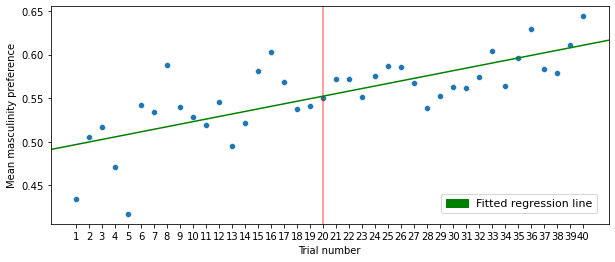

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.scatterplot(data=data.groupby("trial_number")["chose_masc"].mean(), ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)))
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
abline_plot(model_results=trial_time_model, ax=ax, color="green");
plt.legend(handles=[patches.Patch(color='green', label='Fitted regression line')], fontsize=11, loc=(0.7, 0.05)); 

The datapoints on the earlier trials have high residuals and high leverage over the result.

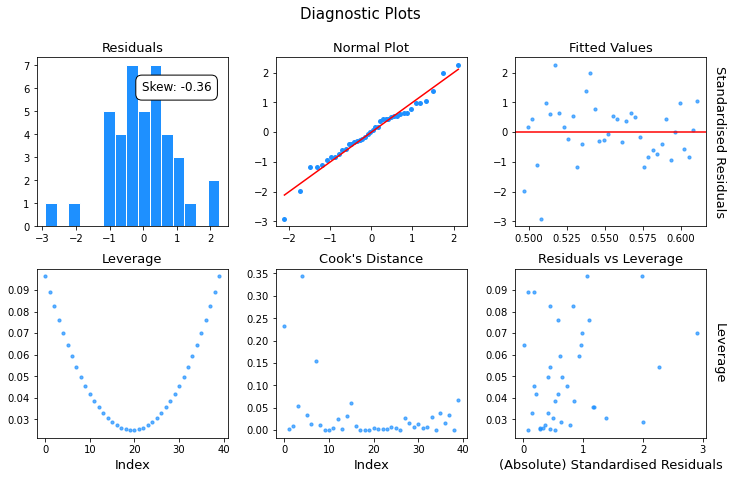

In [12]:
residual_plots(trial_time_model)

## Exponential + linear model for masculinity preference over time

Fitting an exponential model to the masculinity preference over time data:

In [13]:
def fit_explin(X, p0=0.5, p1=0.005, p2=1, p3=0.5):
    return p0 + p1*X - p2*np.exp(-p3*X)

In [14]:
model_result = Model(fit_explin, independent_vars=["X"]).fit(data.groupby("trial_number")["chose_masc"].mean(), X=list(range(1, 41)))
param_df = pd.DataFrame(json.loads(model_result.params.dumps())["params"], columns=["name", "value", "vary", "N3","N4","N5","N6","Std","N8","Ini","N10"])[["name", "value", "vary","Std","Ini"]]
param_text = [r"$P_" + str(param)[-1] + " = " + str(np.round(param_df[param_df["name"]==param]["value"].values[0], 4)) 
              + " \pm " + str(np.round(param_df[param_df["name"]==param]["Std"].values[0], 5)) + "$ \n" for param in param_df["name"]]

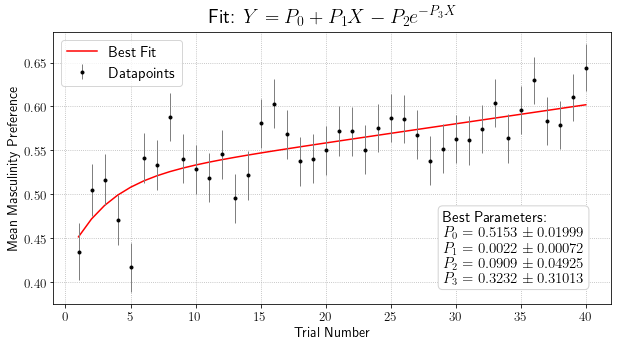

In [15]:
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.plot(range(1, 41), model_result.best_fit, '-',color='red', label='Best Fit')
ax.errorbar(range(1, 41), data.groupby("trial_number")["chose_masc"].mean(), yerr=data.groupby("trial_number")["chose_masc"].sem(), fmt='.k' ,ecolor='gray', elinewidth=1, label='Datapoints')

ax.text(29, 0.4, "Best Parameters:\n" +"".join(param_text)[:-2], size=15, 
        bbox=dict(boxstyle='round',edgecolor='lightgray', facecolor='white', alpha=1))
ax.set_xlabel("Trial Number", size=14), ax.set_ylabel("Mean Masculinity Preference", size=14)
ax.set_title(r'Fit: $Y = P_0 + P_1X-P_2e^{-P_3X}$', size=20, pad=10)
plt.xticks(fontsize=13), plt.yticks(fontsize=13), ax.grid(True, ls='dotted')
plt.legend(fontsize=15);

In [16]:
plt.rcParams['text.usetex'] = False

## Masculinity preference over time by priming group

Plotting the percent of preference for masculinity for each trial (i.e. over time), separated by priming group:

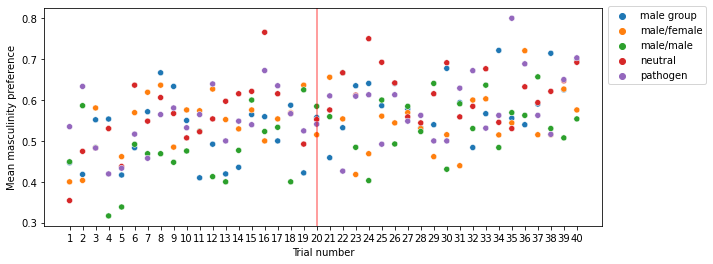

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.scatterplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc"].mean().reset_index(),
                x="trial_number", y="chose_masc", hue="prime_condition_names", ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.legend(loc=(1.01, 0.65))
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

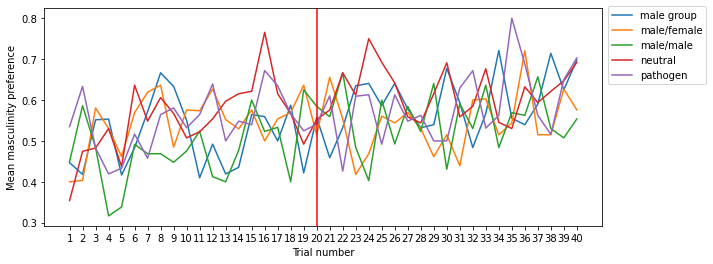

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc"].mean().reset_index(),
                x="trial_number", y="chose_masc", hue="prime_condition_names", ax=ax)
ax.axvline(20, color="red", alpha=1, markersize=2)
plt.legend(loc=(1.01, 0.65))
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

Fitting a model, with both trial number and categorical priming conditions as explanatory variables.

In [19]:
trial_time_prime_model = smf.ols(formula="chose_masc ~ trial_number + C(prime_condition_names)", 
                                data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc"].mean().reset_index()).fit()
trial_time_prime_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             chose_masc   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     12.87
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           8.23e-11
Time:                        19:34:17   Log-Likelihood:                 242.41
No. Observations:                 200   AIC:                            -472.8
Df Residuals:                     194   BIC:                            -453.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.4933      0.015     33.419      0.000       0.464       0.522
C(prime_condition_names)[T.male/female]    -0.0081      0.016     -0.494      0.622      -0.040       0.024
C(prime_condition_names)[T.male/male]      -0.0384      0.016     -2.349      0.020      -0.071      -0.006
C(prime_condition_names)[T.neutral]         0.0332      0.016      2.032      0.043       0.001       0.065
C(prime_condition_names)[T.pathogen]        0.0132      0.016      0.806      0.421      -0.019       0.045
trial_number                                0.0029      0.000      6.576      0.000       0.002       0.004
==============================================================================
Omnibus:                        2.201   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.333   Jarque-Bera (JB):                1.889
Skew:                           0.117   Prob(JB):                        0.389
Kurtosis:                       2.585   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
Fitting a model to each priming condition individually - is there evidence that masculinity preference changes over time?   
For all of the groups, except for male/female, there is evidence that the masculinity preference increases over time.

In [20]:
for i in range(1, 6):
    print("priming group", {1:"neutral",2:"male/male",3:"male group",4:"male/female",5:"pathogen"}[i], "p-value:",
          np.round(smf.ols(formula="chose_masc ~ trial_number", 
                  data=data[data["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()).fit().pvalues[1], 4))

priming group neutral p-value: 0.0012
priming group male/male p-value: 0.0019
priming group male group p-value: 0.0005
priming group male/female p-value: 0.2983
priming group pathogen p-value: 0.0054


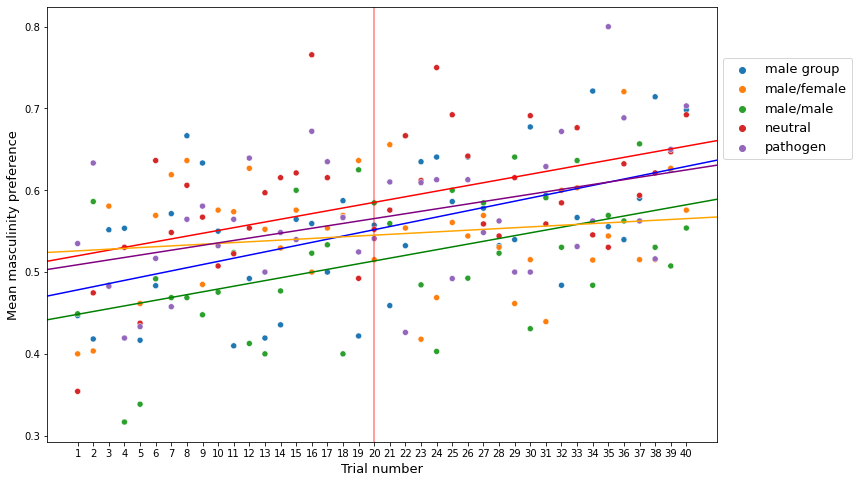

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc"].mean().reset_index(),
                x="trial_number", y="chose_masc", hue="prime_condition_names", ax=ax)
ax.axvline(20, color="red", alpha=0.5), plt.legend(loc=(1.01, 0.65), fontsize=13)
plt.xticks(list(range(1, 41)))
ax.set_ylabel("Mean masculinity preference", fontsize=13), ax.set_xlabel("Trial number", fontsize=13)
for i, colour in zip(range(1, 6), ["red", "green", "blue", "orange", "purple"]):
    abline_plot(ax=ax, color=colour,
                model_results=smf.ols(formula="chose_masc ~ trial_number", 
                                      data=data[data["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()).fit())

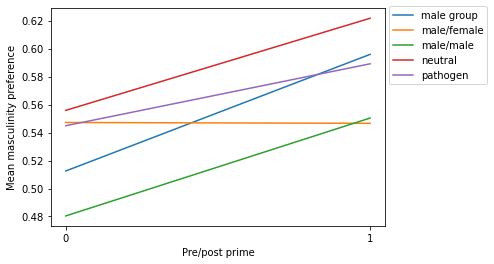

In [22]:
ax = sns.lineplot(data=data.groupby(["prime_condition_names", "pre_post_prime"])["chose_masc"].mean().reset_index(),
                x="pre_post_prime", y="chose_masc", hue="prime_condition_names")
plt.legend(loc=(1.01, 0.65)), ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Pre/post prime"), plt.xticks([0, 1]);

## Modelling alternate datasets

What if you reverse the correction of the slide 10 masculinity side? What if you remove the b participants from the dataset? Do the results change?
(spoiler: no)

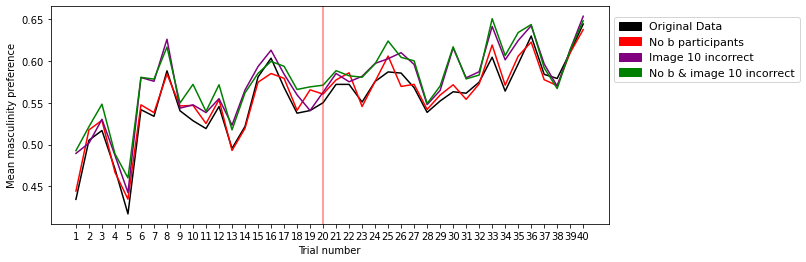

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby("trial_number")["chose_masc"].mean(), color="black", ax=ax)
sns.lineplot(data=data_no_b.groupby("trial_number")["chose_masc"].mean(), color="red", ax=ax)
sns.lineplot(data=data_10_wrong.groupby("trial_number")["chose_masc"].mean(), color="purple", ax=ax)
sns.lineplot(data=data_10_wrong_no_b.groupby("trial_number")["chose_masc"].mean(), color="green", ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)));
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.legend(handles=[patches.Patch(color='black', label='Original Data'), 
                    patches.Patch(color='red', label='No b participants'), 
                    patches.Patch(color='purple', label='Image 10 incorrect'), 
                    patches.Patch(color='green', label='No b & image 10 incorrect')], 
           fontsize=11, loc=(1.01, 0.65)); 

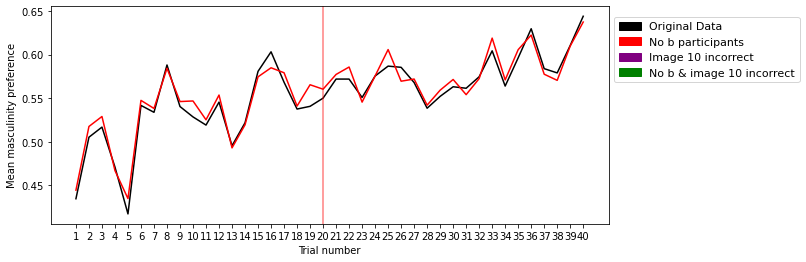

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby("trial_number")["chose_masc"].mean(), color="black", ax=ax)
sns.lineplot(data=data_no_b.groupby("trial_number")["chose_masc"].mean(), color="red", ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)));
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.legend(handles=[patches.Patch(color='black', label='Original Data'), 
                    patches.Patch(color='red', label='No b participants'), 
                    patches.Patch(color='purple', label='Image 10 incorrect'), 
                    patches.Patch(color='green', label='No b & image 10 incorrect')], 
           fontsize=11, loc=(1.01, 0.65)); 

Testing if the slope of each priming group is significant, for each of the modified datasets:

In [25]:
# removing b participants
for i in range(1, 6):
    print("priming group", {1:"neutral",2:"male/male",3:"male group",4:"male/female",5:"pathogen"}[i], "p-value:",
          smf.ols(formula="chose_masc ~ trial_number", 
                  data=data_no_b[data_no_b["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()).fit().pvalues[1])

priming group neutral p-value: 0.0013268666919510651
priming group male/male p-value: 0.006209483821119405
priming group male group p-value: 0.0004181646619607238
priming group male/female p-value: 0.2641940525018325
priming group pathogen p-value: 0.013379255273002242


In [26]:
# reversing the image 10 choices
for i in range(1, 6):
    print("priming group", {1:"neutral",2:"male/male",3:"male group",4:"male/female",5:"pathogen"}[i], "p-value:",
          smf.ols(formula="chose_masc ~ trial_number", 
                  data=data_10_wrong[data_10_wrong["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()).fit().pvalues[1])

priming group neutral p-value: 0.0003045597520255751
priming group male/male p-value: 0.003324701156389682
priming group male group p-value: 0.0008880123650238579
priming group male/female p-value: 0.9243010159304956
priming group pathogen p-value: 0.013727287445485402


In [27]:
# removing b participants and reversing the image 10 choices
for i in range(1, 6):
    print("priming group", {1:"neutral",2:"male/male",3:"male group",4:"male/female",5:"pathogen"}[i], "p-value:",
          smf.ols(formula="chose_masc ~ trial_number", 
                  data=data_10_wrong_no_b[data_10_wrong_no_b["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()).fit().pvalues[1])

priming group neutral p-value: 0.00027472015337318796
priming group male/male p-value: 0.008122681984176868
priming group male group p-value: 0.0009300945492617779
priming group male/female p-value: 0.7938864438207479
priming group pathogen p-value: 0.03183009734579923


## Removing the first 5 trials

Does removing the first 5 trials from the dataset change the results (overall and for each priming group?)

Do we see the same exponential increase in the first 5 trials for all of the priming groups?  
Answer: not really! We only really see the same pattern in the "neutral" group, whereas groups like "pathogen" seem much more linear for the entirety of the trials.

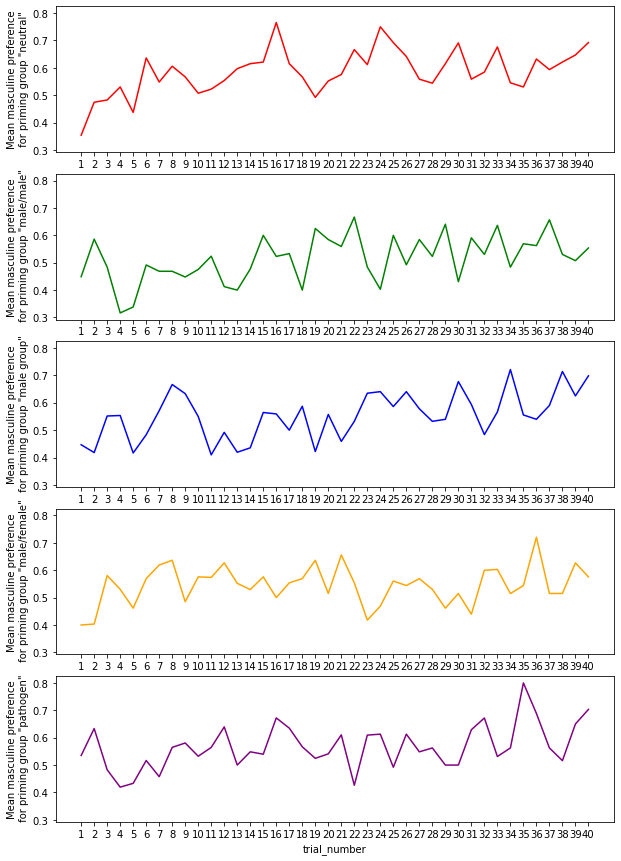

In [28]:
prime_names = list(data["prime_condition_names"].unique())
prime_cols = ["red", "green", "blue", "orange", "purple"]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,15), sharey=True)
fig.subplots_adjust(hspace=0.15)
for i in range(0, len(prime_names)):
    ax = axes.ravel()[i]
    ax.set_ylabel("Mean masculine preference\n for priming group " + "\"" + prime_names[i] + "\"")
    sns.lineplot(data=data[data["prime_condition_names"]==prime_names[i]].groupby("trial_number")["chose_masc"].mean(), color=prime_cols[i], ax=ax)
    ax.set_xticks(list(range(1, 41)));

Fitting a model to the whole overall dataset, with and without the first 5 trials:

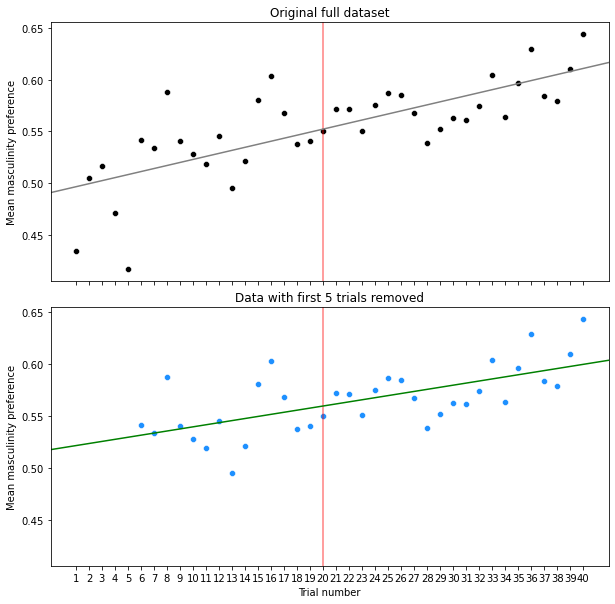

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.1)

ax1.set_title("Original full dataset")
sns.scatterplot(data=data.groupby("trial_number")["chose_masc"].mean(), color="black", ax=ax1)
ax1.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)))
ax1.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
abline_plot(model_results=trial_time_model, ax=ax1, color="grey");

ax2.set_title("Data with first 5 trials removed")
sns.scatterplot(data=data.groupby("trial_number")["chose_masc"].mean()[5:], color="dodgerblue", ax=ax2)
ax2.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)))
ax2.set_ylabel("Mean masculinity preference"), ax2.set_xlabel("Trial number")
abline_plot(model_results=smf.ols(formula="chose_masc ~ trial_number", data=data.groupby("trial_number")["chose_masc"].mean().reset_index()[5:]).fit(), 
            ax=ax2, color="green");

If we model the data with the first 5 trials removed, there is still a significant slope, but this slope is much less steep than in the original full dataset.

In [30]:
smf.ols(formula="chose_masc ~ trial_number", data=data.groupby("trial_number")["chose_masc"].mean().reset_index()[5:]).fit().pvalues[1]

2.6084403575374426e-05

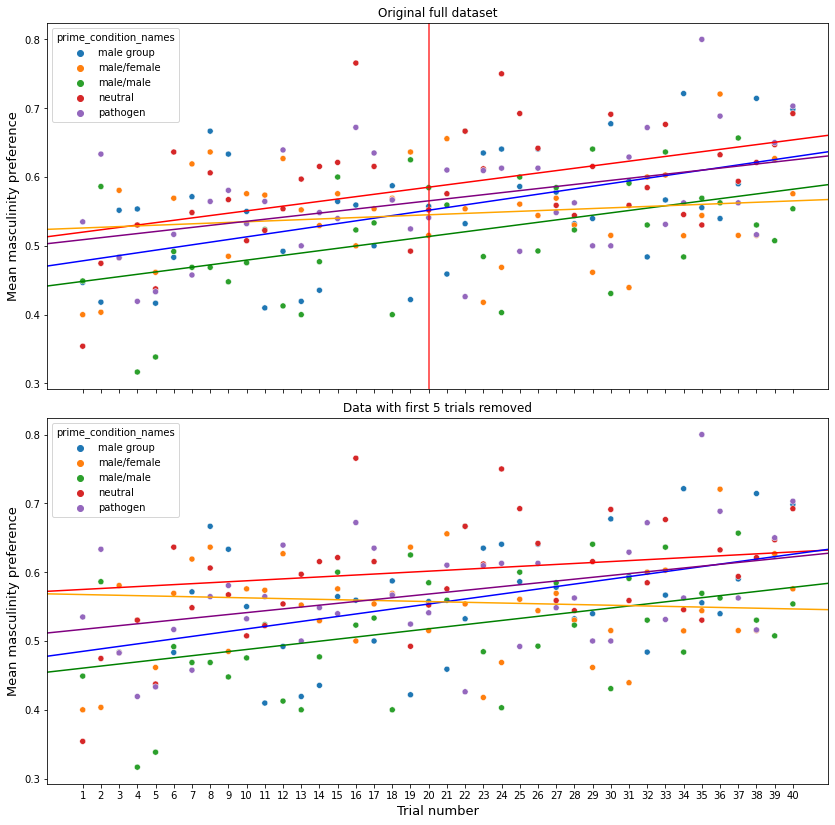

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.08)

ax1.set_title("Original full dataset")
sns.scatterplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc"].mean().reset_index(),
                x="trial_number", y="chose_masc", hue="prime_condition_names", ax=ax1)
ax1.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)))
ax1.set_ylabel("Mean masculinity preference", fontsize=13)
for i, colour in zip(range(1, 6), ["red", "green", "blue", "orange", "purple"]):
    abline_plot(ax=ax1, color=colour,
                model_results=smf.ols(formula="chose_masc ~ trial_number", 
                                      data=data[data["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()).fit())
    
ax2.set_title("Data with first 5 trials removed")
sns.scatterplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc"].mean().reset_index()[5:],
                x="trial_number", y="chose_masc", hue="prime_condition_names", ax=ax2)
ax1.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)))
ax2.set_ylabel("Mean masculinity preference", fontsize=13), ax2.set_xlabel("Trial number", fontsize=13)
for i, colour in zip(range(1, 6), ["red", "green", "blue", "orange", "purple"]):
    abline_plot(ax=ax2, color=colour,
                model_results=smf.ols(formula="chose_masc ~ trial_number", 
                                      data=data[data["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()[5:]).fit())

In [32]:
for i in range(1, 6):
    print("priming group", {1:"neutral",2:"male/male",3:"male group",4:"male/female",5:"pathogen"}[i], "p-value:",
          smf.ols(formula="chose_masc ~ trial_number", 
                  data=data[data["prime_condition"]==i].groupby("trial_number")["chose_masc"].mean().reset_index()[5:]).fit().pvalues[1])

priming group neutral p-value: 0.20278154227373768
priming group male/male p-value: 0.014250271167650236
priming group male group p-value: 0.007206353244750107
priming group male/female p-value: 0.6220568166041763
priming group pathogen p-value: 0.0320613967472601


When the first 5 trials are removed, the neutral group no longer has a significant slope. It seems like the overall increase in the masculinity preferences over time is mainly driven by the results from the male/male and male group priming conditions.

## Individual participants masculinity preferences

Looking at individual participants' masculinity preferences over time:

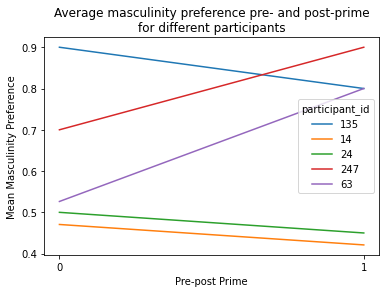

In [33]:
ax = sns.lineplot(data=data[data["participant_id"].isin(["14", "24", "63", "135", "247"])].groupby(["participant_id", "pre_post_prime"])["chose_masc"].mean().reset_index(),
                x="pre_post_prime", y="chose_masc", hue="participant_id");

ax.set_title("Average masculinity preference pre- and post-prime\nfor different participants")
ax.set_xlabel("Pre-post Prime")
ax.set_ylabel("Mean Masculinity Preference");
plt.xticks([0, 1]);

We can see strongly different starting baseline masculinity preferences between the participants.

The ways in which their preferences change over time (the slopes) are also different - how much of this is due to the priming group they were assigned to?